# Computer Vision (911.908)

## <font color='crimson'>Adaptive Linear Neuron (AdaLine)</font>

**Changelog**:
- *Sep. 2020*: initial version (using PyTorch v1.6) 
- *Sep. 2021*: adaptations to PyTorch v1.9


In this part, we briefly look at **AdaLine**, i.e., a simple early neural network model (Widrow & Hoff, 1960).

Basically, the adaptive linear neuron is very similar to the Perceptron, with the only difference that the activation function is **linear**.

---

## Contents

- [Model](#Model)
- [Learning rule](#AdaLine-learning-rule)
- [Implementation](#Implementation)

---

## Model

We are given $(\mathbf{x}_i,y_i)$ for $i=1,\ldots,n$ with $\mathbf{x}_i \in \mathbb{R}^n$ and $y_i \in \{0,1\}$. Also, we augment $\mathbf{x}_i$ by 1 at position 0 to obtain $\mathbf{x}_i = [1,x_{i1},\ldots,x_{in}]^\top \in \mathbb{R}^{n+1}$. Similar to the perceptron, we compute

$$ \hat{y} = f(\mathbf{x},\mathbf{w}) = \phi(\langle \mathbf{w},\mathbf{x}\rangle)$$

where $\mathbf{w} = [w_0,w_1,\ldots,w_n]^\top$ includes the bias term $w_0$ and

$$
\phi(z) = \mathbf{1}_{z>0.5} = \begin{cases}
1, & \text{if}~z>1/2 \\
0, & \text{else}
\end{cases}
$$

is a simple threshold function at $1/2$. 

Another difference to the Perceptron is in the **learning rule**: in particular, we *do not* measure whether we were correct at the output (under 0/1 loss), but rather consider the *mean-squared-error* after the activation function ($\text{id}$) with respect to the target (which is in $\{0,1\}$).



<img src="Adaline.svg" alt="drawing" width="400"/>

At **evaluation time**, we obviously use the threshold to decide whether a new $\mathbf{x}^*$ should be assigned 0 or 1.

---

## AdaLine learning rule

The original AdaLine learning rule (aka *Widrow-Hoff* learning rule) updates the weights $\mathbf{w}^{(t)}$ via

$$ \mathbf{w}^{(t+1)} \leftarrow \mathbf{w}^{(t)} + \eta(d-o)\mathbf{x}$$

per sample, where $o$ is the output after the identity function and $d$ is the label of the input sample
$\mathbf{x}$.

### Justification

Lets omit the iteration identifier $t$ for a second and also omit the indices, $i$, of the training samples.
Let $\mathbf{x} = [1,x_1,x_2,\ldots,x_n]^\top$ be an input sample in $\mathbb{R}^{n+1}$ (with a 1 added to include bias). This allows us to write

$$ u = \mathbf{w}^\top \mathbf{x}$$

Upon applying the identity activation function, we get

$$ o = \text{id}(u)$$

Lets compute the squared error:

$$E = (o - d)^2$$

and take the partial derivative of $E$ wrt. $\mathbf{w}$:

$$\frac{\partial E}{\partial \mathbf{w}} = \frac{\partial (o-d)^2}{\partial \mathbf{w}} = 2(o-d)\frac{\partial o}{\partial \mathbf{w}} = 2(o-d)\frac{\partial u}{\partial \mathbf{w}} = 2(o-d)\frac{\partial \mathbf{w}^\top \mathbf{x}}{\partial \mathbf{w}} = 2(o-d)\mathbf{x}$$

The negative of this gradient (which we need for gradient descent based learning) is 

$$-\frac{\partial E}{\partial \mathbf{w}} = 2(d-o)\mathbf{x}$$

As we know, moving along the direction of the negative gradient decreases the value of the error function.

Thus, we have obtained the original AdaLine learning rule where the factor 2 is simply *merged* into the learning rate $\eta$.

## Implementation

In [57]:
import torch
from torch.autograd import grad
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Let's read-in some actual data into a `pandas` DataFrame.

In [74]:
df = pd.read_csv(
    '../data/iris.data', 
    index_col=None,
    header=None)

df.head(100)

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,Iris-versicolor
96,5.7,2.9,4.2,1.3,Iris-versicolor
97,6.2,2.9,4.3,1.3,Iris-versicolor
98,5.1,2.5,3.0,1.1,Iris-versicolor


We want to construct a binary classification problem, where class 0 is `Iris-versicolor` and everything else is class 1.

In [75]:
# rename columns in pandas data frame
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']
# restrict the data frame to 100 entries (rows with indices 50+ up to 149)
df = df.iloc[50:150]
# make the problem binary, i.e., Iris-versicolor vs. everything else
df['y'] = df['y'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1) 

# use columns x2 and x3 to make up our inputs x = [x2,x3]
X = torch.tensor(df[['x2', 'x3']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

# create random permutation of indices to shuffle the data
torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
X, y = X[shuffle_idx], y[shuffle_idx]

# take 70% of the data for training, the remaining 30% for testing
percent70 = int(shuffle_idx.size(0)*0.7)
X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

# normalize (mean zero, unit variance) - we only use the mean and std. dev of 
# the training data, since this is the only data we have access to in practice!
mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Ok, lets plot the **input data points**, colored by class (this is our training data).

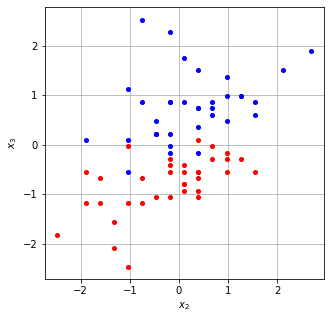

In [76]:
plt.figure(figsize=(5,5))
plt.plot(X_train[np.where(y_train==0)[0],0],X_train[np.where(y_train==0)[0],1], 'r.', markersize=8);
plt.plot(X_train[np.where(y_train==1)[0],0],X_train[np.where(y_train==1)[0],1], 'b.', markersize=8);
plt.grid()
plt.xlabel('$x_2$');
plt.ylabel('$x_3$');

We are now ready to define our **Adaline** model. This is effectively a simple linear model (computing an inner product + bias). We will define the model in the way we will later define more complex neural networks, i.e., using a class derived from `nn.Module`.


In [37]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        m.weight.data.zero_()
        m.bias.data.zero_()

class Adaline(torch.nn.Module):
    def __init__(self, num_features):
        super(Adaline, self).__init__()

        # implements <w,x> + b, i.e., an affine map from R^n -> R
        self.linear = torch.nn.Linear(num_features, 1) 
    
    def forward(self, x):
        u = self.linear(x)   # u = <w,x> + b
        o = u                # activation = identity
        return o.view(-1)    # vectorize

Next, we define how we measure the **quality** of the network output (i.e., the predictions). 

In Adaline, this **quality** measure is simply the *mean-squared error (MSE)*, measuring the squared difference between the network output (after the activation function) and the desired values.

In [90]:
def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=123, minibatch_size=20):
    
    cost = []
    torch.manual_seed(seed)
    
    # set the optimizer to SGD 
    optimizer = torch.optim.SGD(
        model.parameters(), # model parameters to optimize over, in our model w and b
        lr=learning_rate)
    
    # Run num_epoch times over the training data
    for e in range(num_epochs):
        # set training mode to True
        model.train()
        
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

        # create indices for mini-batches 
        minibatches = torch.split(
            shuffle_idx, 
            minibatch_size)
        
        # compute gradient w.r.t. this selection of samples
        for minibatch_idx in minibatches:

            yhat = model.forward(x[minibatch_idx])     # forward pass
            loss = F.mse_loss(yhat, y[minibatch_idx])  # compute loss (i.e., mean-squared error)
            optimizer.zero_grad()                      # set gradients to zero
            loss.backward()                            # backward pass to compute gradients
            optimizer.step()                           # update the AdaLine parameters (w,b)

        # compute the loss over ALL training data! Note: with lots of data points, you would also 
        # do this over mini batches!
        with torch.no_grad():
            model.eval()
            yhat = model.forward(x)
            curr_loss = F.mse_loss(yhat, y)
            print('Epoch: %03d' % (e+1), end="")
            print(' | MSE: %.5f' % curr_loss)
            cost.append(curr_loss)

    return cost

Lets instantiate this model and train!

Epoch: 001 | MSE: 0.52738
Epoch: 002 | MSE: 0.42493
Epoch: 003 | MSE: 0.34932
Epoch: 004 | MSE: 0.29330
Epoch: 005 | MSE: 0.25109
Epoch: 006 | MSE: 0.21895
Epoch: 007 | MSE: 0.19434
Epoch: 008 | MSE: 0.17533
Epoch: 009 | MSE: 0.16037
Epoch: 010 | MSE: 0.14862
Epoch: 011 | MSE: 0.13926
Epoch: 012 | MSE: 0.13181
Epoch: 013 | MSE: 0.12570
Epoch: 014 | MSE: 0.12073
Epoch: 015 | MSE: 0.11675
Epoch: 016 | MSE: 0.11343
Epoch: 017 | MSE: 0.11069
Epoch: 018 | MSE: 0.10843
Epoch: 019 | MSE: 0.10656
Epoch: 020 | MSE: 0.10499
Epoch: 021 | MSE: 0.10368
Epoch: 022 | MSE: 0.10257
Epoch: 023 | MSE: 0.10164
Epoch: 024 | MSE: 0.10086
Epoch: 025 | MSE: 0.10018
Epoch: 026 | MSE: 0.09960
Epoch: 027 | MSE: 0.09911
Epoch: 028 | MSE: 0.09869
Epoch: 029 | MSE: 0.09835
Epoch: 030 | MSE: 0.09805
Epoch: 031 | MSE: 0.09780
Epoch: 032 | MSE: 0.09759
Epoch: 033 | MSE: 0.09740
Epoch: 034 | MSE: 0.09724
Epoch: 035 | MSE: 0.09711
Epoch: 036 | MSE: 0.09699
Epoch: 037 | MSE: 0.09689
Epoch: 038 | MSE: 0.09680
Epoch: 039 |

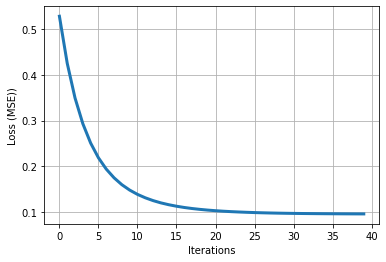

In [91]:
model = Adaline(num_features=2)
cost = train(model, 
             X_train, y_train.float(),
             num_epochs=40,
             learning_rate=0.01,
             seed=123,
             minibatch_size=10)

plt.plot(cost, linewidth=3);
plt.xlabel('Iterations');
plt.ylabel('Loss (MSE))');
plt.grid()

We are now ready to evaluate the performance of the Adaline network on **training** data:

In [92]:
# set model to evaluation mode
model.eval()

# run a forward pass through model, detach the result 
# from the comp. graph and convert it to a numpy array
yhat_train = model.forward(X_train).detach().numpy()

# create an array of all-zeros
ylab_train = np.zeros_like(yhat_train, dtype=np.int32)

# apply threshold (at 0.5): predictions > 0.5 get label 1, all others are 0
ylab_train[np.where(yhat_train>0.5)[0]]=1

# compute accuracy
print('Train accuracy: {:.3f}'.format((ylab_train == y_train.numpy()).sum()/len(ylab_train)))

Train accuracy: 0.900


... and now on unseen **testing** data:

In [93]:
model.eval()
yhat_test = model.forward(X_test).detach().numpy()
ylab_test = np.zeros_like(yhat_test, dtype=np.int32)
ylab_test[np.where(yhat_test>0.5)[0]]=1

print('Test accuracy: {:.3f}'.format((ylab_test == y_test.numpy()).sum()/len(ylab_test)))

Test accuracy: 0.933


## More convenience via `Dataset` and `DataLoader`

In [94]:
class CustomDataSet(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super().__init__()
        
        self.X = X.astype('float32')
        self.y = y.astype('float32')
        
        assert(self.X.shape[0] == self.y.shape[0])
        
    def __getitem__(self, idx):
        return self.X[idx,:], self.y[idx]

    def __len__(self):
        return self.X.shape[0]
    

def get_data(file_name, p=0.7):
    df = pd.read_csv(file_name, index_col=None, header=None)
    df = df.iloc[50:150]
    df.columns = ['x1', 
                  'x2', 
                  'x3', 
                  'x4', 
                  'y']
    
    df['y'] = df['y'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1)
    
    shuffle_idx =  np.random.permutation(len(df))
    X = df[['x2', 'x3']].values[shuffle_idx]
    y = df['y'].values[shuffle_idx]
    
    N = int(len(shuffle_idx)*p)
    X_trn, X_tst = X[shuffle_idx[:N]], X[shuffle_idx[N:]]
    y_trn, y_tst = y[shuffle_idx[:N]], y[shuffle_idx[N:]]
    
    mu, sigma = X_trn.mean(axis=0), X_trn.std(axis=0)
    X_trn = (X_trn - mu) / sigma
    X_tst = (X_tst - mu) / sigma
    
    return X_trn, y_trn, X_tst, y_tst

In [95]:
from torch.utils.data import DataLoader

X_trn, y_trn, X_tst, y_tst = get_data('../data/iris.data')

ds_trn = CustomDataSet(X_trn, y_trn)
ds_tst = CustomDataSet(X_tst, y_tst)

dl_trn = DataLoader(ds_trn, batch_size=20, shuffle=True)
dl_tst = DataLoader(ds_tst, batch_size=20, shuffle=False)

The following code contains parts we have not yet discussed in the lecture (e.g., the use of *Stochastic Gradient Descent* and *mini-baches*) - it primarily illustrates how PyTorch's `DataLoader` is used. 

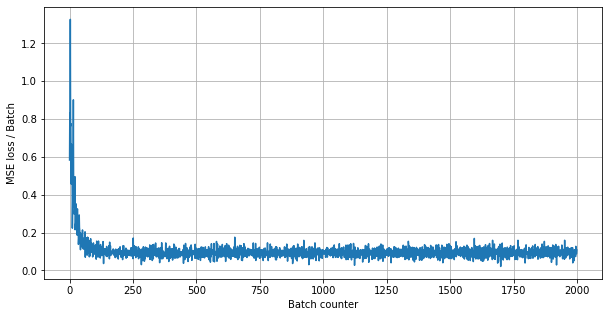

In [101]:
model = Adaline(num_features=2)
optim = torch.optim.SGD(model.parameters(), lr=0.01)

it_loss = []

for n_epoch in range(500):
    for x, target in dl_trn:
        optim.zero_grad()
        yhat = model(x)
        loss = F.mse_loss(yhat, target) 
        loss.backward()
        optim.step()
        it_loss.append(loss.item())   

plt.figure(figsize=(10,5))
plt.plot(it_loss)
plt.xlabel('Batch counter');
plt.ylabel('MSE loss / Batch');
plt.grid()

In [102]:
model.eval()
correct = 0
for x, target in dl_tst:
    y = model(x).detach().numpy()
    yhat = np.zeros_like(y)
    yhat[np.where(y>0.5)[0]]=1
    correct += (yhat == target.numpy()).sum()

print('Test accuracy: {:.2f}'.format(correct/len(ds_tst)))

Test accuracy: 0.93
